In [121]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from Extra_funcs import wavelength_to_rgb


ImportError: cannot import name 'wavelength_to_rgb' from 'Extra_funcs' (c:\DATA\Université\Maitrise\LabOMC Github\TemplatesSnippets\QuantumYield\QY with standard\Extra_funcs.py)

This code snippet is meant to take files issued from the EMspec montage in the 0307 lab at the COPL and transform the tab delimited .txt output files into graphs for visualization and potentially presentation in papers or presentations. The cell below contains a function that converts the raw .txt output to a numpy array.

In [55]:
def txt_to_data(path):
    """Generates a numpy array from the tab-delimited txt output files of the EMspec montage

    Args:
        path (string): Relative path of the txt file to be transformed

    Returns:
        data: A 2D numpy array containing the wavelengths in nm in the first column and the counts in the second column
    """
    raw_data = open(path).read()
    data = []
    for i in raw_data.split("\n")[17:-2]:
        data += [i.split("\t")]
    return np.array(data).astype(float)

In [117]:
file = "Fluorescien data/XM260127-18.txt"
spectrum = txt_to_data(file)
wavelengths = spectrum[:,0]
raw_counts = spectrum[:,1]
fil_counts = gaussian_filter1d(raw_counts, sigma = 3)

def data_2_peaks(wavel, counts, peaks):
    out = []
    for i in peaks:
        out += [[wavel[i], counts[i]]]
    return np.array(out)

peaks, props = find_peaks(fil_counts, prominence = 0.6, height = 100)
raw_peaks = data_2_peaks(wavelengths, raw_counts, peaks)
fil_peaks = data_2_peaks(wavelengths, fil_counts, peaks)

print(fil_peaks)

[[406.56       481.12622483]
 [516.2        638.14974386]]


<function matplotlib.pyplot.show(close=None, block=None)>

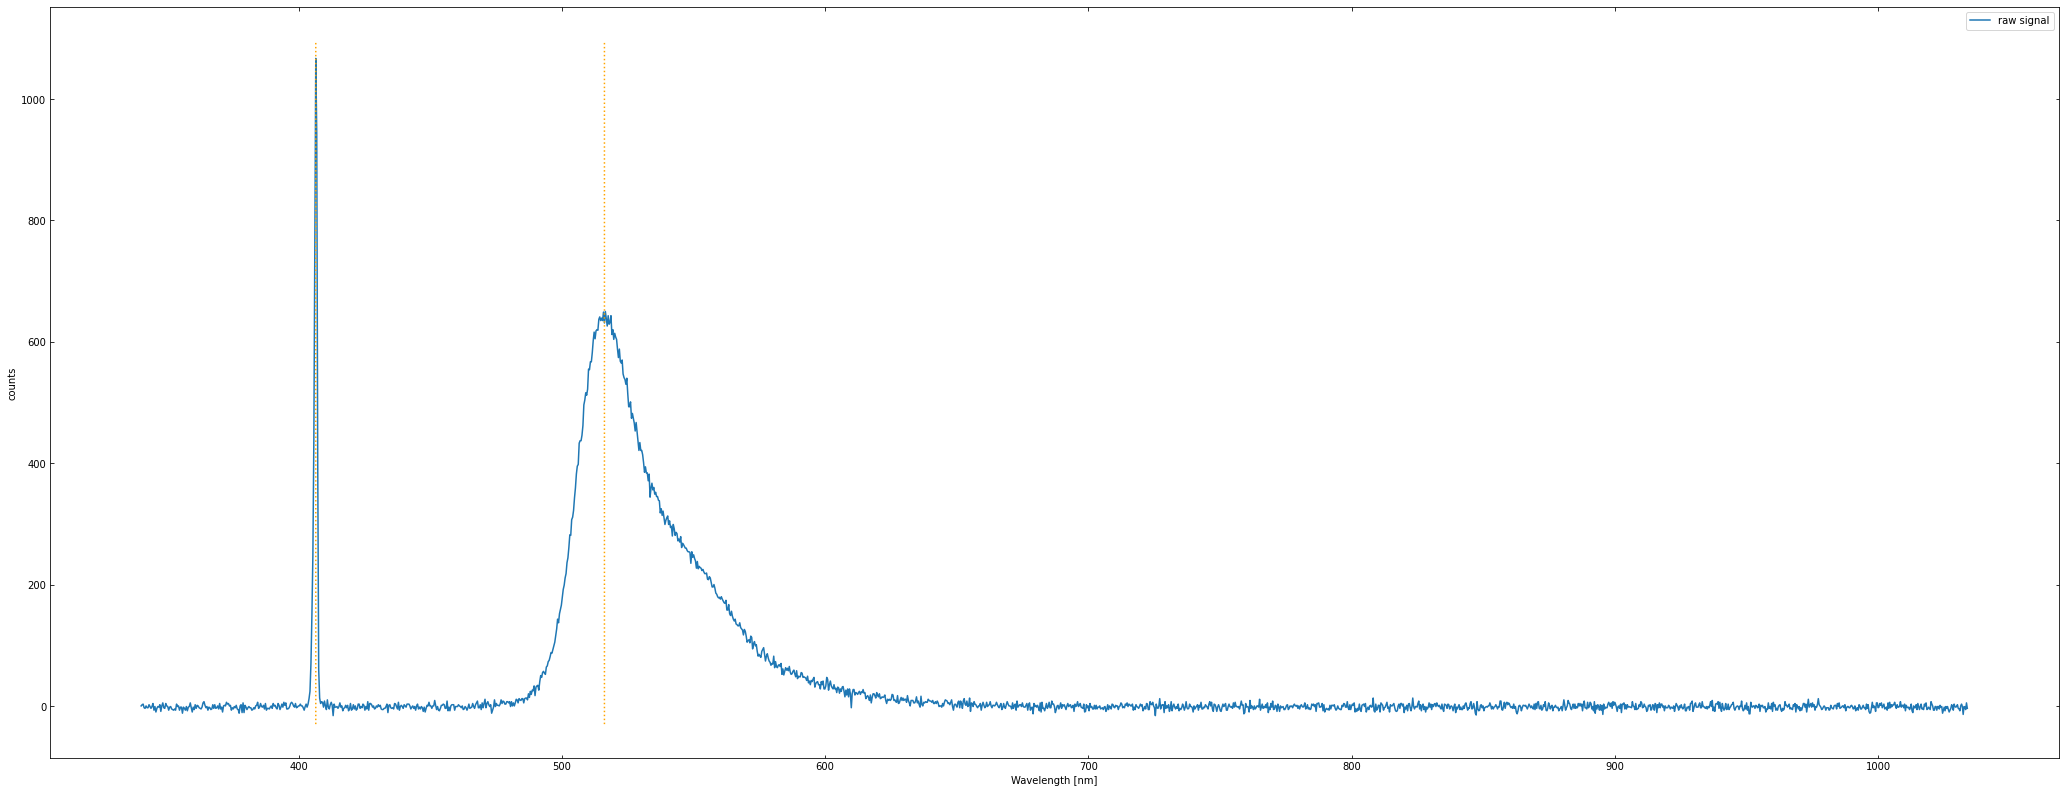

In [ ]:
fig, ax = plt.subplots(figsize=(36, 18))
fig.subplots_adjust(bottom=0.3)

y_range = np.arange(-30, raw_counts.max()+30)
ones = np.ones(y_range.shape)


plt.plot(wavelengths, raw_counts, label = "raw signal")
#plt.plot(wavelengths, fil_counts, label = "filtered signal")
for i in raw_peaks:
    plt.plot(ones*i[0], y_range, c = "orange", ls = ":", label = )



ax.tick_params("both", direction = "in", top = True, right = True)
plt.xlabel("Wavelength [nm]")
plt.ylabel("counts")
plt.legend()
plt.show